In [2]:
import numpy as np
import tensorflow as tf
import random
import pickle
import scipy
import matplotlib.pyplot as plt
from d_u import load_CIFAR10
import structures
from amirata_functions import *
from pylab import rcParams
from tqdm import tqdm_notebook as tqdm
from CNN_class import CNN_SC
import scipy
import scipy.stats as stats
config_gpu = tf.ConfigProto()
config_gpu.gpu_options.allow_growth = True

In [2]:
data,aux_data = get_CIFAR10_data("../datasets/cifar-10-batches-py")
mean_image=data["mean_image"]

In [57]:
def tf_l2_distance_expert(a,b):
    num_classes=tf.shape(b)[0]
    num_centers=tf.shape(b)[1]
    hidden_dim = tf.shape(b)[2]
    b = tf.reshape(b,[-1,hidden_dim])
    norm_a = tf.reduce_sum(a**2,axis=1,keep_dims=True)
    norm_b = tf.reduce_sum(tf.transpose(b)**2,axis=0,keep_dims=True)
    output = -2*tf.matmul(a,tf.transpose(b))
    output += norm_a
    output += norm_b
    out = tf.sqrt(output)
    return tf.reshape(output,[-1,num_classes,num_centers])

def l2_distance_expert(a,b):
    num_centers=1
    if len(b.shape)>2:
        num_centers=b.shape[1]
    num_classes=b.shape[0]
    b = np.reshape(b,[-1,b.shape[-1]])
    norm_a = np.sum(a**2,axis=1,keepdims=True)
    norm_b = np.sum((b.T)**2,axis=0,keepdims=True)
    output = -2*np.dot(a,(b.T)) + norm_a + norm_b
    out = np.sqrt(output)
    if num_centers>1:
        return np.reshape(output,[-1,num_classes,num_centers])
    else:
        return out  
    
# def tf_l2_distance_expert(a,b,num_centers,hidden_dim=1024, 
#                           num_classes=10):
#     b = tf.reshape(b,[-1,hidden_dim])
#     norm_a = tf.reduce_sum(a**2,axis=1,keep_dims=True)
#     norm_b = tf.reduce_sum(tf.transpose(b)**2,axis=0,keep_dims=True)
#     output = -2*tf.matmul(a,tf.transpose(b))
#     output += norm_a
#     output += norm_b
#     out = tf.sqrt(output)
#     if num_centers>1:
#         return tf.reshape(output,[-1,num_classes,num_centers])
#     else:
#         return out    
    

    
def tf_self_distances(a):
    norm=tf.norm(a,axis=1,keep_dims=True)**2
    return 2*norm-2*tf.matmul(a,tf.transpose(a))
    

In [60]:
class CNN_centers(object):
    
    def __init__(self,  num_centers, centers_dist, network_name,
                 num_conv_layers, num_forward_layers, input_shape,
                 num_classes, path,kernel_sizes, hidden_sizes, 
                 pool_sizes, dims, learning_rate = 0.001, 
                 padding = "SAME", initialize=False,dropout = 1, 
                 reject_cost = 0.2, activation="relu",reg = 0,
                 dynamic = False, batch_norm=True, loss_coeff=0):
        self.network_name = network_name
        self.centers_dist=centers_dist
        self.num_forward_layers = num_forward_layers
        self.num_conv_layers = num_conv_layers
        self.batch_norm = batch_norm
        self.input_shape = input_shape 
        #FIXIT: assumption is images are square
        self.dims = dims
        self.loss_coeff=loss_coeff
        self.padding = padding
        self.learning_rate = learning_rate
        self.pool_sizes = pool_sizes
        self.hidden_sizes = hidden_sizes
        self.kernel_sizes = kernel_sizes
        self.num_classed = num_classes
        self.dropout = dropout
        self.dynamic = dynamic
        self.num_classes = num_classes
        self.path = path
        self.reg = reg
        self.flatten_size = self.flatten_size_calculator()
        self.Pdic = self.make_Pdic()
        self.initialize = initialize
        self.num_centers=num_centers
        self.dropout_ph = tf.placeholder(tf.float32)
        self.input_ph = tf.placeholder\
        (dtype= tf.float32,shape= [None, self.input_shape[0],self.\
                                   input_shape[1],self.input_shape[2]])
        self.output_ph = tf.placeholder(dtype= tf.int32, shape= [None,])
        self.is_training_ph = tf.placeholder(tf.bool)
        self.activation = self.get_activation(activation)
        self.build(self.input_ph)
        
    def make_Pdic(self):
        
        Pdic = {}
        
        Pdic["W"] = tf.get_variable\
        ("W", shape = [self.hidden_sizes[self.num_forward_layers-1]\
                       ,self.num_classes],initializer=\
         tf.contrib.layers.xavier_initializer())
        Pdic["b"] = tf.get_variable("b", shape=[self.num_classes],\
                                    initializer=tf.zeros_initializer())
        
        self.sum_weights = tf.reduce_sum( Pdic["W"]**2)
        
        flat_length = self.flatten_size[self.num_conv_layers-1]
        
        for number in range(self.num_conv_layers):
            Pdic["K{}".format(number)] =  tf.get_variable\
            ("K{}".format(number),shape=[self.kernel_sizes[number]\
                                         ,self.kernel_sizes[number]\
                                         ,(number==0)*self.input_shape[-1]\
                                         + (number>0)*self.dims[number-1],\
                                         self.dims[number]],initializer=\
             tf.contrib.layers.xavier_initializer())
            Pdic["z{}".format(number)] = tf.get_variable\
            ("z{}".format(number), shape = [self.dims[number]],\
             initializer=tf.zeros_initializer())
        
        for layer in range(self.num_forward_layers):
            
            Pdic["W{}".format(layer)] = tf.get_variable\
            ("W{}".format(layer),shape=[flat_length*(layer==0)+\
                                        self.hidden_sizes[layer-1]*(layer>0)\
                                        ,self.hidden_sizes[layer]],
                                 initializer=\
             tf.contrib.layers.xavier_initializer())
            self.sum_weights += tf.reduce_sum( Pdic["W{}".format(layer)]**2)
            Pdic["b{}".format(layer)] = tf.get_variable\
            ("b{}".format(layer),shape=[self.hidden_sizes[layer]]\
             , initializer=tf.zeros_initializer())
        return Pdic
        


    def get_activation(self, name):
        if name == "relu":
            return tf.nn.relu
        if name == "tanh":
            return tf.nn.tanh
        if name == "sigmoid":
            return tf.sigmoid
    
    
    def conv_layer(self, number, feed):
        
        conv = tf.nn.conv2d(input=feed, filter=self.Pdic["K{}".format(number)]\
                            , padding="SAME", strides=[1,1,1,1])
        out_convv =\
        self.activation(conv + self.Pdic["z{}".format(number)])
        if self.batch_norm:
            out_conv = tf.layers.batch_normalization\
            (out_convv,axis=-1,training=self.is_training_ph)
        else:
            out_conv = out_convv
        pool = tf.layers.max_pooling2d\
        (inputs=out_conv, pool_size=self.pool_sizes[number],\
         strides=self.pool_sizes[number])
        return pool
    
    def fc_layer(self, layer, feed):
        out = tf.matmul(feed,self.Pdic["W{}".format(layer)])+\
        self.Pdic["b{}".format(layer)]
        out_relued = tf.nn.dropout(self.activation(out), 
                                   self.dropout_ph)
        return out_relued
    
    def flatten_size_calculator(self):
        if self.num_conv_layers:
            output = np.zeros(self.num_conv_layers)
            temp = self.input_shape[0]//self.pool_sizes[0]
            output[0] = temp*temp*self.dims[0]
            for n in range(1,self.num_conv_layers):
                temp = temp//self.pool_sizes[n]
                output[n] = temp*temp*self.dims[n]
        else:
            output = np.array([self.input_shape[0]*self.input_shape[1]*\
            self.input_shape[2]])
        return output.astype(int)
    
        
    def build(self, feed):
        # FIXIT: assumption is all convolutions are square
        out = feed
        for layer in range(self.num_conv_layers):
            out = self.conv_layer(layer, out)
        flat_length = self.flatten_size[self.num_conv_layers-1]
        out = tf.reshape(out, shape=[-1, flat_length])
        for layer in range(self.num_forward_layers):
            out = self.fc_layer(layer,out)
        self.hidden = out
        self.dic = {}
        self.centers_init=self.centers_dist*\
        np.random.random((self.num_classes,self.num_centers,
                         self.hidden_sizes[-1]))
        self.centers_var=tf.cast(tf.Variable(self.centers_init),
                                 tf.float32)   
        labels = tf.cast(tf.one_hot(self.output_ph,self.num_classes),\
                         tf.float32)
        self.distances = tf_l2_distance_expert(self.hidden,
                                               self.centers_var)

        self.min_distance = tf.reduce_min(self.distances,axis=-1)
        self.which_center = tf.argmin(self.distances, axis=-1)
        self.dic["cost_h"] =\
        tf.reduce_mean(tf.reduce_sum(self.min_distance * labels,axis=1))-\
        self.loss_coeff*tf.reduce_sum(tf_self_distances\
        (tf.reshape(self.centers_var,[-1,self.hidden_sizes[-1]])))\
        +0.5*self.reg*(self.sum_weights)
        
        
        
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):                                                                       
            self.dic["optmz_h"]= tf.train.AdamOptimizer\
            (self.learning_rate).minimize(self.dic["cost_h"])
            
    def get_batches(self, training_data, batch_size, validation_data):   
        Xs = training_data[0]
        Ys = training_data[1]
        mask = np.random.permutation(len(Ys))
        Xs = Xs[mask]
        Ys = Ys[mask]
        X_batches = [Xs[k:k + batch_size] for k in range(0, len(Xs)\
                                                         , batch_size)]
        Y_batches = [Ys[k:k + batch_size] for k in range(0, len(Ys)\
                                                         , batch_size)]
        return X_batches, Y_batches, validation_data[0], validation_data[1]


    def do_epoch(self, sess, epoch, X_batches, Y_batches, X_val, Y_val,
                 X_train, Y_train, verbose):
        avg_cost = 0
        mskn = np.random.choice(range(X_train.shape[0]),len(X_val))
        x_train = X_train[mskn]
        y_train = Y_train[mskn]
        for X_batch, Y_batch in zip(X_batches, Y_batches):
            sess.run(self.dic["optmz_h"],
                     feed_dict={self.input_ph:X_batch,
                                self.output_ph:Y_batch,
                                self.is_training_ph:True,
                               self.dropout_ph:self.dropout})
        val_h = sess.run(self.hidden,
                         feed_dict={self.input_ph:X_val,
                                    self.is_training_ph:False,
                                    self.dropout_ph:1})
        val_cost = sess.run(self.dic["cost_h"],
                            feed_dict={self.input_ph:X_val,
                                       self.output_ph:Y_val,
                                       self.is_training_ph:False,
                                       self.dropout_ph:1})
        acc, rate = self.evaluate(val_h,Y_val)
        tr_h = sess.run(self.hidden,
                        feed_dict={self.input_ph:x_train,
                                   self.is_training_ph:False,
                                   self.dropout_ph:1})
        tr_cost = sess.run(self.dic["cost_h"],
                           feed_dict={self.input_ph:x_train,
                                      self.output_ph:y_train,
                                      self.is_training_ph:False,
                                      self.dropout_ph:1})
        acc_train, _ = self.evaluate(tr_h,y_train)
        if verbose:
            print("Epoch:{}".format(epoch))
            print("Val/Train Accuracy:{}/{}".format(acc,acc_train))
            print("Val/Train Cost:{}/{}".format(val_cost,tr_cost))
            if rate<1:
                print("rate:{}").format(rate)
        return acc
    
    def tradeoff(self,sess, X_val, Y_val):
        self.acc_hist = []
        self.rate_hist = []
        self.thresh_list = []
        val_h = sess.run(self.hidden,\
                         feed_dict={self.input_ph:X_val,\
                                    self.is_training_ph:False,
                                    self.dropout_ph:1})
        r=0.
        thresh = 1e5*1.
        while(r<0.95):
            thresh /= 1.001
            self.thresh_list.append(thresh)
            a,r = self.evaluate(val_h,Y_val,thresh)
            r = 1-r
            self.acc_hist.append(a)
            self.rate_hist.append(r)
#                 print(thresh,a,r)
          
    def give_back_centers(self,X_train,y_train):
        orig_centers=np.zeros((self.num_classes,self.num_centers,
                              self.input_shape[0],self.input_shape[1],
                              self.input_shape[2]))
        for i in range(self.num_classes):
            args = np.where(y_train==i)[0]
            args_center = np.random.choice(args,self.num_centers)
            orig_centers[i]=X_train[args_center]
        orig_centers=np.reshape(orig_centers,[self.num_classes*self.num_centers,
                                              self.input_shape[0],self.input_shape[1],
                                               self.input_shape[2]])
        return orig_centers
    
    def optimize(self,  training_data, validation_data,
                 save, load , reg= 0, epochs=10,batch_size= 200, 
                 tradeoff=False, verbose=True, save_always=False, loss_coeff=0):
        
        X_batches, Y_batches, X_val, Y_val = \
        self.get_batches(training_data, batch_size, validation_data)
        X_train = training_data[0]
        Y_train = training_data[1]
        self.orig_centers=self.give_back_centers(X_train,Y_train)
        saver = tf.train.Saver()
        init = tf.global_variables_initializer()
        
            
        with tf.Session(config=config_gpu) as sess:
            sess.run(init)
            best_val = 0.
#             if self.num_centers>1:
#                 initilization_centers = \
#                 tf.reshape(self.feedforward(self.orig_centers,sess),
#                            [self.num_classes,self.num_centers,
#                                   self.hidden_sizes[-1]])
#             else:
#                 initilization_centers =\
#                 self.feedforward(self.orig_centers,sess)
             
            self.centers=sess.run(self.centers_var)   
            if load:
                if verbose:
                    print("Loading model from :{}".format(self.path))
                saver.restore(sess,self.path)
            self.centers,val_h = sess.run([self.centers_var,self.hidden],\
                             feed_dict={self.input_ph:X_val,\
                                        self.is_training_ph:False,
                                        self.dropout_ph:1})
            best_val, _ = self.evaluate(val_h,Y_val)
            if verbose:
                print("validation accuracy before starting",best_val)

            for epoch in range(epochs):
                print(np.linalg.norm\
                      (self.centers-sess.run(self.centers_var)))
                self.centers=sess.run(self.centers_var)
                acc = self.do_epoch(sess, epoch, X_batches, Y_batches,
                                    X_val, Y_val,X_train,
                                    Y_train, verbose)
                if acc>=best_val or save_always: #FIXIT
                    best_val = acc
                    saved_path = saver.save(sess, self.path)
                    if verbose and not save_always:
                        print("New best!")
            self.best_val = best_val 
            print("Best val accuracy:",self.best_val)
            saver.restore(sess,self.path)
            if tradeoff:
                self.tradeoff(sess, X_val, Y_val)

    def predict(self, hidden):
        index = -1
        counter = 0.
        correct = 0.
        out = np.zeros(hidden.shape[0])
        diff_tensor =\
        tf.minimum(tf_l2_distance_expert(tf.constant(hidden)
                                         ,self.centers_var),axis=-1)
        diff=sess.run(diff_tensor)
        out = np.argmin(diff,axis=1)
        return out
    
    def adversary(self, feed, epsilon, true_label, mode="BIM",
                  sess=None,max_iter=10):
        if sess==None:
            sess=get_session()
            saver = tf.train.Saver()
            saver.restore(sess,self.path)
        net_label=np.argmax(self.feedforward(feed,sess),1)
        if net_label!=true_label:
            print("Network is already misclassifying")
            return
        adv = feed
        iters=0
        if mode=="BIM":
            cont=True
            while(cont and iters<max_iter):
                iters += 1
                gradient = sess.run(tf.gradients(self.dic["cost_h"],
                                        self.input_ph)[0],
                                    feed_dict={self.input_ph:adv,
                                   self.is_training_ph:False,
                                   self.output_ph:true_label,
                                   self.dropout_ph:1})
                adv = feed+np.clip(adv+epsilon*np.sign(gradient)-feed,
                                  -epsilon,epsilon)
                out_adv = self.feedforward(adv,sess)
                print("True label:",true_label,"New label:",
                     np.argmax(out_adv,1),"Confidence:",
                     np.max(out_adv,1))
                if np.argmax(out_adv,1)!=\
                true_label and np.max(out_adv,1)>0.95:
                    cont=False
        return adv
            
    def evaluate(self, hidden, y, thresh=1e100):  
        correct = 0.
        if self.num_centers>1:
            diff = np.min(l2_distance_expert(hidden,self.centers),
                          axis=-1)
        else:
            diff = l2_distance(hidden,self.centers)
        passed = np.min(diff,1)<thresh
        passed_num = np.sum(passed)
        correct = np.argmin(diff,1) == y     
        return np.sum(correct*passed)*1./passed_num,\
    passed_num*1./y.shape[0]
    
    def feedforward(self, feed, sess=None):
        if sess==None:
            sess=get_session()
            saver = tf.train.Saver()
            saver.restore(sess,self.path)  
        output = sess.run\
        (self.hidden, {self.input_ph: feed,
                       self.is_training_ph : False,
                       self.dropout_ph:1})

In [ ]:
training_data = (data["X_train"][:40000],data["y_train"][:40000])
validation_data1 = (aux_data["X_val1"],aux_data["y_val1"])
tf.reset_default_graph()
network_F = CNN_centers(num_centers = 10, centers_dist=10,
                        network_name="network1",
                        num_conv_layers=3, num_forward_layers=1,
                  input_shape=[32,32,3], reg = 1e-2,num_classes=10,
                        kernel_sizes=[5,5,5], hidden_sizes=[1024], 
                  pool_sizes=[2,2,2], padding = "same",
                        path ="saved_networks/1C_5L_T", loss_coeff=0.1,
                  dims=[64,128,256], learning_rate = 1e-3, 
                        batch_norm = True, dropout = 1)
network_F.optimize(training_data, validation_data1,
                   epochs=50, load = False, save = True)
            

gooz
validation accuracy before starting 0.1045
0.0
Epoch:0
Val/Train Accuracy:0.597/0.6165
Val/Train Cost:-19044102.0/-19044308.0
New best!
66.3689
Epoch:1
Val/Train Accuracy:0.7065/0.7225
Val/Train Cost:-21461680.0/-21461902.0
New best!
70.4393
Epoch:2
Val/Train Accuracy:0.7275/0.78
Val/Train Cost:-24154216.0/-24154926.0
New best!
73.0305
Epoch:3
Val/Train Accuracy:0.748/0.814
Val/Train Cost:-27125724.0/-27126726.0
New best!
74.7987
Epoch:4
Val/Train Accuracy:0.755/0.8705
Val/Train Cost:-30375504.0/-30377256.0
New best!
76.016
Epoch:5
Val/Train Accuracy:0.7435/0.8875
Val/Train Cost:-33899372.0/-33901920.0
76.8353
Epoch:6
Val/Train Accuracy:0.773/0.9235
Val/Train Cost:-37692836.0/-37695924.0
New best!
77.3572
Epoch:7
Val/Train Accuracy:0.759/0.935
Val/Train Cost:-41748644.0/-41752648.0
77.653
Epoch:8
Val/Train Accuracy:0.764/0.9405
Val/Train Cost:-46060432.0/-46065336.0
77.7759
Epoch:9
Val/Train Accuracy:0.762/0.963
Val/Train Cost:-50621908.0/-50627988.0
77.7664
Epoch:10
Val/Train Acc

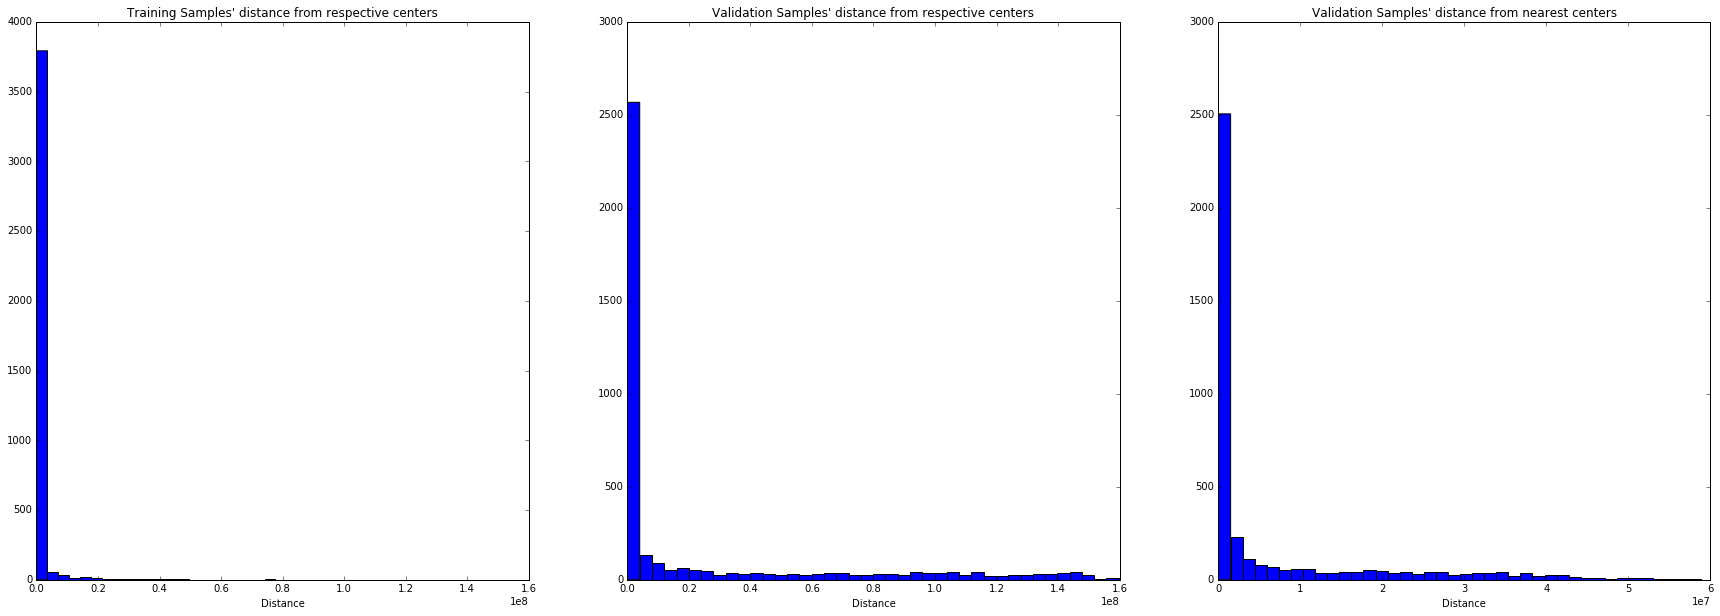

In [107]:
%matplotlib inline
network1 = network_T_1000_0
from pylab import rcParams
rcParams['figure.figsize'] = 30, 10
plt.figure(1)
x = X_train[:4000]
y = y_train[:4000]
gooz,dists = network1.hist_dist(x,y)
plt.subplot(131)
plt.hist(gooz,bins=40)
plt.xlabel("Distance")
plt.title("Training Samples' distance from respective centers")
x = X_val[:4000]
y = y_val[:4000]
gooz,dists = network1.hist_dist(x,y)
plt.subplot(132)
plt.hist(gooz,bins=40)
plt.xlabel("Distance")
plt.title("Validation Samples' distance from respective centers")
plt.subplot(133)
plt.hist(np.min(dists,1),bins=40)
plt.xlabel("Distance")
plt.title("Validation Samples' distance from nearest centers")

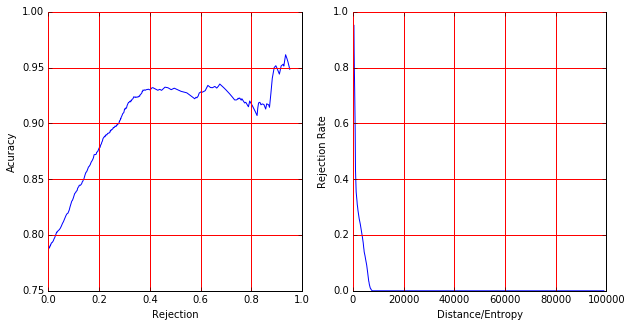

In [108]:
network1 = network_T_1000_0
list1 = network1.rate_hist
list2 = network1.acc_hist
list3 = network1.thresh_list

%matplotlib inline  
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
plt.figure(1)
plt.subplot(122)
plt.plot(list3[-2000:],list1[-2000:])
plt.grid(color='r', linestyle='-', linewidth=1)
plt.xlabel("Distance/Entropy")
# plt.xscale('log')
plt.ylabel("Rejection Rate")
plt.subplot(121)
plt.plot(list1,list2)
plt.grid(color='r', linestyle='-', linewidth=1)
plt.xlabel("Rejection")
plt.ylabel("Acuracy")



In [32]:
list2[0]

0.91574999999999995

In [ ]:
    %matplotlib inline  
    plt.scatter(network1.thresh_list[-10:],network1.rate_hist[-10:])
    plt.grid(color='r', linestyle='-', linewidth=1)
    plt.xlabel("Distance")
    plt.ylabel("Rejection Rate")